## Libraries


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean, rolling_max, rolling_min, rolling_std
from mlforecast.target_transforms import Differences
import datetime as dt
import os
from colorama import Fore, Style


## Data Loading


In [3]:
%cd C:\Users\balti_j80n85d\Desktop\MODEL

C:\Users\balti_j80n85d\Desktop\MODEL


In [4]:
Y_GPRS = pd.read_csv('GPRS_DATA.csv')
gprs_data = pd.read_csv('gprs_data_total.csv')

Y_GPRS['ds'] = pd.to_datetime(Y_GPRS['ds'])
gprs_data['date'] = pd.to_datetime(gprs_data['date'])

BEST_PARAMS = pd.read_csv('best_params_FINAL_BE3_W_RAWA7.csv')
priority = pd.read_csv('Categorisation.csv')

**Data seperation**

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    float: MAPE value as a percentage.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
service = 'GPRS' 

countries = ['United Kingdom','Germany','Belgium','Spain','Netherlands','Poland','Austria','Slovakia','Czech Republic',
            'Ireland','Hungary','Bulgaria','Romania','Greece','Luxembourg', 
            'Croatia','Italy','France','Portugal','Sweden','Denmark','Norway','Finland','Estonia','Lithuania','Latvia',
            'Malta','Cyprus','Slovenia']

affiliates = ['France', 'Poland', 'Romania', 'Belgium', 'Spain', 'Slovakia', 'Luxembourg']

gprs_relations = [a + ',' + c for a in affiliates for c in countries if a != c]
gprs_data = gprs_data[gprs_data.relation.isin(gprs_relations)]
gprs_data['date'] = pd.to_datetime(gprs_data['date'])
gprs_data['year'] = pd.DatetimeIndex(gprs_data['date']).year
gby = gprs_data.groupby('relation')['volume_chargeable'].sum().reset_index()
sorted_gprs_relations = gby.sort_values(by = 'volume_chargeable', ascending=False).relation.values

In [6]:
BEST_PARAMS.index = ['n_estimators', 'learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'min_child_weight', 'rolling_window_size_1', 'rolling_window_size_2']

In [7]:
BEST_PARAMS

,"France,Spain","Poland,Germany","France,Italy","France,Belgium","France,Portugal","Romania,Germany","Belgium,France","France,Germany","Spain,France","France,United Kingdom",...,"Slovakia,Lithuania","Luxembourg,Finland","Luxembourg,Slovakia","Luxembourg,Norway","Luxembourg,Slovenia","Slovakia,Estonia","Luxembourg,Latvia","Luxembourg,Cyprus","Luxembourg,Estonia","Luxembourg,Lithuania"
n_estimators,207.000000,585.000000,940.000000,985.000000,507.000000,648.000000,562.000000,274.000000,268.000000,743.000000,...,928.000000,508.000000,372.000000,699.000000,100.000000,376.000000,301.000000,526.000000,491.000000,374.000000
learning_rate,0.011123,0.034060,0.024850,0.013627,0.016141,0.096987,0.054996,0.013301,0.026299,0.063583,...,0.048924,0.011512,0.087160,0.022085,0.063848,0.011618,0.016591,0.095393,0.074313,0.017003
max_depth,101.000000,121.000000,49.000000,17.000000,10.000000,168.000000,181.000000,53.000000,176.000000,193.000000,...,110.000000,53.000000,61.000000,189.000000,128.000000,149.000000,107.000000,92.000000,55.000000,124.000000
subsample,0.467564,0.545001,0.890419,0.480279,0.959610,0.191670,0.254329,0.565899,0.604519,0.714079,...,0.898827,0.566838,0.403619,0.788362,0.920773,0.460686,0.999216,0.591806,0.709164,0.426335
colsample_bytree,0.475637,0.183450,0.091777,0.277540,0.521534,0.909652,0.749149,0.579356,0.760394,0.094204,...,0.505496,0.349059,0.584030,0.488579,0.892824,0.050095,0.966860,0.316329,0.745181,0.507316
min_child_weight,3.000000,1.000000,10.000000,1.000000,5.000000,3.000000,7.000000,3.000000,9.000000,10.000000,...,7.000000,9.000000,1.000000,8.000000,5.000000,1.000000,12.000000,13.000000,6.000000,19.000000
rolling_window_size_1,14.000000,24.000000,23.000000,10.000000,14.000000,11.000000,11.000000,13.000000,12.000000,12.000000,...,19.000000,18.000000,8.000000,19.000000,19.000000,9.000000,12.000000,23.000000,8.000000,11.000000
rolling_window_size_2,14.000000,15.000000,22.000000,17.000000,6.000000,9.000000,10.000000,21.000000,21.000000,23.000000,...,12.000000,20.000000,12.000000,23.000000,6.000000,17.000000,20.000000,11.000000,13.000000,19.000000


In [9]:
def Xgboost(data, BEST_PARAMS, uid):
    data['unique_id'] = uid
    best_params =  dict(BEST_PARAMS[uid])
    for ind in ['n_estimators', 'max_depth', 'min_child_weight', 'rolling_window_size_1', 'rolling_window_size_2']:
        best_params[ind] = best_params[ind].astype(int)
    best_param_xgb = {k: v for k, v in best_params.items() if k not in ['rolling_window_size_1', 'rolling_window_size_2']}
    best_param_xgb["objective"] = "reg:absoluteerror"

    model = MLForecast(models=[XGBRegressor(**best_param_xgb)],
                        freq='MS',
                        lags = [1,12],
                        lag_transforms={
                            1: [(rolling_mean, best_params['rolling_window_size_1']), (rolling_max, best_params['rolling_window_size_1']), 
                                (rolling_min, best_params['rolling_window_size_1']), (rolling_std, best_params['rolling_window_size_1'])],
                            6: [(rolling_mean,best_params['rolling_window_size_2'])],
                            12: [(rolling_mean, best_params['rolling_window_size_2'])],
                        },
                        num_threads=2,
                        date_features=['quarter'],
                        target_transforms=[Differences([12])],)

    model.fit(data, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
    
    return model

In [10]:
suffix = '_2023_EU_DEMO'

output_path_plots = os.path.join('results' + suffix, service + '_result_plots')

if not os.path.exists(output_path_plots): os.makedirs(output_path_plots)

output_path_test_predictions = os.path.join('results' + suffix, service + '_test_predictions')
if not os.path.exists(output_path_test_predictions): os.makedirs(output_path_test_predictions)

output_path_train_predictions = os.path.join('results' + suffix, service + '_train_predictions')
if not os.path.exists(output_path_train_predictions): os.makedirs(output_path_train_predictions)

models = ['Xgboost']

In [11]:
priority['Success'] = 0
priority['Partial Success'] = 0
for p in priority['Catégorie'].unique() :
    if p== 'P0' : 
        priority.loc[priority['Catégorie']== p,'Success'] = 5
        priority.loc[priority['Catégorie'] == p,'Partial Success'] = 8    
    if p== 'P1' : 
        priority.loc[priority['Catégorie']== p,'Success'] = 10
        priority.loc[priority['Catégorie'] == p,'Partial Success'] = 15
    if p== 'P2' : 
        priority.loc[priority['Catégorie']== p,'Success'] = 15
        priority.loc[priority['Catégorie'] == p,'Partial Success'] = 20
priority.to_csv('Priority.csv')

In [12]:
XGB_fcts = []
mapes = pd.DataFrame({
    'unique_id': sorted_gprs_relations,
    'mape': None
})

pd.options.mode.chained_assignment = None  
s = 0
p_s = 0
f = 0
Train_dfs ={}
Test_dfs = {}
Future_dfs = {}
Forecasted_dfs = {}
for i, relation in enumerate(sorted_gprs_relations):
    country_source = relation.split(',')[0]
    country_destination = relation.split(',')[1]
    P = priority.loc[priority['country_destination'] == country_destination, 'Catégorie'].values[0]
    ts = gprs_data[gprs_data['relation'] == relation].drop('relation', axis = 1)
    ts['date'] = pd.to_datetime(ts['date'])
    
    test = pd.DataFrame()
    test['date'] = pd.to_datetime(['2022-'+str(i)+'-01' for i in range(9, 13)] +['2023-'+str(i)+'-01' for i in range(1, 13)])
    test['COVID'] = 0
    test['volume_chargeable'] = 0
    
    if relation == 'France,Belgium':
         train = ts[(ts['date'] >= '2017-01-01') & (ts['date'] < '2022-09-01')] 
    else:
         train = ts[(ts['date'] >= '2017-01-01') & (ts['date'] < '2022-09-01')] 
    
    
    activate_BREXIT = False
    if country_source == 'Spain' and country_destination == 'United Kingdom':
        activate_BREXIT = True
        train['BREXIT'] = np.where((train['date'] >= '2022-05'), 1, 0)
        test['BREXIT'] = 1
    
    if country_source == 'Romania' and country_destination == 'United Kingdom':
        activate_BREXIT = True
        train['BREXIT'] = np.where(train['date'] >= '2021-07', 1, 0)
        test['BREXIT'] = 1
        
    if country_source == 'Poland' and country_destination == 'United Kingdom':
        activate_BREXIT = True
        train['BREXIT'] = np.where(train['date'] >= '2021-10', 1, 0)   
        test['BREXIT'] = 1
    
    t_covid_start = dt.datetime(2020,1,1)
    t_covid_end = dt.datetime(2022,2,1)
    train['COVID'] = 0
    train.loc[(train['date']>= t_covid_start) & (train['date']<= t_covid_end),'COVID']=1
    
    y_hat_test = test.copy()
    y_hat_train = train.copy()
    h=16
    models=['Xgboost']

    if 'Xgboost' in models:
        train.rename(columns = {'date': 'ds', 'volume_chargeable': 'y'}, inplace = True)

        if not activate_BREXIT:
            model_XGB = Xgboost(train[['ds','y', 'COVID']], BEST_PARAMS , relation)
            future_XGB = model_XGB.make_future_dataframe(h)
            pt =  train[['ds','y', 'COVID']]
            pt['unique_id'] = relation
            Train_dfs[f'{relation}'] =  pt 
        else:
            model_XGB  = Xgboost(train[['ds','y', 'COVID', 'BREXIT']], BEST_PARAMS , relation)                                      
            future_XGB = model_XGB.make_future_dataframe(h)
            future_XGB['BREXIT'] = 1
            pt =  train[['ds','y', 'COVID', 'BREXIT']]
            pt['unique_id'] = relation
            Train_dfs[f'{relation}'] =  pt 


        future_XGB['COVID'] = 0
        if activate_BREXIT :
            future_XGB['BREXIT'] = 1
        forecast_XGB = model_XGB.predict(h, X_df = future_XGB)
        y_hat_test['Xgboost'] = list(forecast_XGB['XGBRegressor'])
        pTS = future_XGB.copy()
        pTS['y'] = list(ts[ (ts['date']>='2022-09-01')&(ts['date']<'2024-01-01') ]['volume_chargeable'])
        Test_dfs[f'{relation}'] = pTS 
        Future_dfs[f'{relation}'] =  future_XGB 
        Forecasted_dfs[f'{relation}'] = y_hat_test['Xgboost']
        m = mean_absolute_percentage_error(pTS['y'], y_hat_test['Xgboost'] )
        mapes.loc[mapes['unique_id']==relation, 'mape'] = m

        if P == "P0" :
            success = 5
            partial_success = 8
        elif P == "P1" :
            success = 10
            partial_success = 15
        elif P == "P2" :
            success = 15
            partial_success = 20
        
        if m <= success :
            objective = 1
            s+=1
            color = Fore.GREEN
        elif m <= partial_success :
            objective = 0.5
            p_s+=1
            color = Fore.YELLOW
        else :
            objective = 0
            f+=1
            color = Fore.RED

        print(color + 'relation =', relation , "(",i,"/ 196)", " MAPE =", str(mapes.loc[mapes['unique_id']==relation, 'mape'].values[0]) + Style.RESET_ALL)

KeyboardInterrupt: 

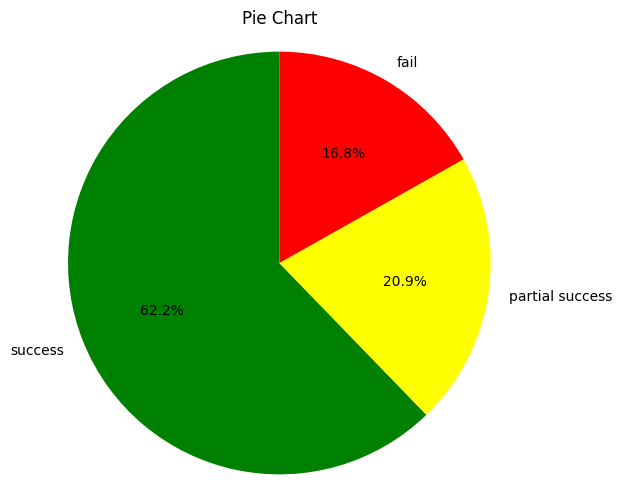

In [12]:
# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie([s, p_s, f], labels=['success', 'partial success', 'fail'], autopct='%1.1f%%', startangle=90, colors=['green','yellow','red'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title('Pie Chart')

# Show the plot
plt.show()

In [13]:
mapes

,unique_id,mape
0,"France,Spain",6.393074
1,"Poland,Germany",3.909012
2,"France,Italy",11.713925
3,"France,Belgium",2.036083
4,"France,Portugal",8.434468
...,...,...
191,"Luxembourg,Slovenia",13.268802
192,"Slovakia,Estonia",16.557061
193,"Luxembourg,Latvia",33.025058
194,"Luxembourg,Cyprus",19.796671


In [14]:
pd.DataFrame(list(mapes['mape'])).describe()

,0
count,196.000000
mean,10.334490
std,5.582057
min,2.036083
25%,6.396493
50%,9.040721
75%,13.256743
max,33.025058


**Forecasting**

In [15]:
ranges = {
    '<=5': mapes[mapes['mape'] <= 5]['unique_id'].tolist(),
    '5..8': mapes[(mapes['mape'] > 5) & (mapes['mape'] <= 8)]['unique_id'].tolist(),    
    '8..10': mapes[(mapes['mape'] > 8) & (mapes['mape'] <= 10)]['unique_id'].tolist(),
    '10..15': mapes[(mapes['mape'] > 10) & (mapes['mape'] <= 15)]['unique_id'].tolist(),
    '15..20': mapes[(mapes['mape'] > 15) & (mapes['mape'] <= 20)]['unique_id'].tolist(),
    '20..40': mapes[(mapes['mape'] > 20) & (mapes['mape'] <= 40)]['unique_id'].tolist(),
    '>40': mapes[(mapes['mape'] > 40)]['unique_id'].tolist(),
}

In [16]:
performance_per_filiale_pays = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in ranges.items()]))

In [17]:
performance_per_filiale_pays

,<=5,5..8,8..10,10..15,15..20,20..40,>40
0,"Poland,Germany","France,Spain","France,Portugal","France,Italy","Spain,United Kingdom","Poland,Croatia",NaN
1,"France,Belgium","Romania,Germany","Poland,Italy","Belgium,France","Romania,Greece","Poland,Greece",NaN
2,"France,Germany","Spain,France","Romania,Netherlands","France,Greece","France,Croatia","Slovakia,Croatia",NaN
3,"France,Luxembourg","France,United Kingdom","France,Ireland","Belgium,Spain","Poland,Bulgaria","Slovakia,Greece",NaN
4,"Belgium,Netherlands","Spain,Italy","Romania,Bulgaria","Spain,Portugal","Belgium,Austria","Slovakia,Cyprus",NaN
5,"Romania,Italy","France,Netherlands","Poland,United Kingdom","Belgium,Italy","Spain,Denmark","Romania,Latvia",NaN
6,"Spain,Germany","Romania,France","Luxembourg,Germany","Romania,United Kingdom","Belgium,Croatia","Slovakia,Finland",NaN
7,"Poland,Netherlands","Poland,France","Romania,Poland","France,Norway","Romania,Cyprus","Luxembourg,Norway",NaN
8,"Romania,Hungary","Romania,Austria","Spain,Czech Republic","France,Czech Republic","Slovakia,Bulgaria","Luxembourg,Lithuania",NaN
9,"Luxembourg,France","Poland,Spain","Romania,Sweden","France,Hungary","Luxembourg,Greece","Luxembourg,Latvia",NaN


In [18]:
Global_mape = np.mean(mapes['mape'])
Global_mape

10.334490007688618

In [26]:
pip install openpyxl

   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   ------ -------------------------------- 41.0/250.9 kB 653.6 kB/s eta 0:00:01
   --------- ----------------------------- 61.4/250.9 kB 812.7 kB/s eta 0:00:01
   ------------ -------------------------- 81.9/250.9 kB 508.4 kB/s eta 0:00:01
   ------------------ ------------------- 122.9/250.9 kB 599.1 kB/s eta 0:00:01
   --------------------- ---------------- 143.4/250.9 kB 655.8 kB/s eta 0:00:01
   --------------------- ---------------- 143.4/250.9 kB 655.8 kB/s eta 0:00:01
   ----------------------------- -------- 194.6/250.9 kB 562.0 kB/s eta 0:00:01
   -------------------------------------  245.8/250.9 kB 628.1 kB/s eta 0:00:01
   -------------------------------------- 250.9/250.9 kB 615.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
pd.read_excel("C:/Users/balti_j80n85d/Downloads/merged_dataset (1).xlsx")

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.